In [12]:
!pip install statsmodels scipy matplotlib numpy pandas
#!pip install --upgrade statsmodels


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

Carregando dados...

1. Análise de Tendência Temporal...

2. Análise Estatística Comparativa...


C:\Users\Edmilson\AppData\Local\Temp\ipykernel_10280\798514807.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_title('Comparação entre Cenários\nANOVA p-value: {:.3e}'.format(anova['PR(>F)'][0]))



Resultados ANOVA:
             df        sum_sq       mean_sq          F        PR(>F)
Group       3.0  1.021369e+09  3.404563e+08  10.808065  7.000652e-07
Residual  476.0  1.499410e+10  3.150021e+07        NaN           NaN

Teste de Tukey:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1   group2    meandiff p-adj    lower      upper   reject
--------------------------------------------------------------
    CI        CII -1594.887 0.1244 -3462.9252  273.1512  False
    CI       CIII  -589.534  0.848 -2457.5722 1278.5041  False
    CI Historical 2372.5601 0.0062   504.5219 4240.5982   True
   CII       CIII  1005.353 0.5078  -862.6852 2873.3911  False
   CII Historical 3967.4471    0.0  2099.4089 5835.4853   True
  CIII Historical 2962.0941 0.0003  1094.0559 4830.1323   True
--------------------------------------------------------------

3. Análise de Mudança Estrutural...
Teste F: 4.21, p-value: 0.0160

4. Análise Espectral...


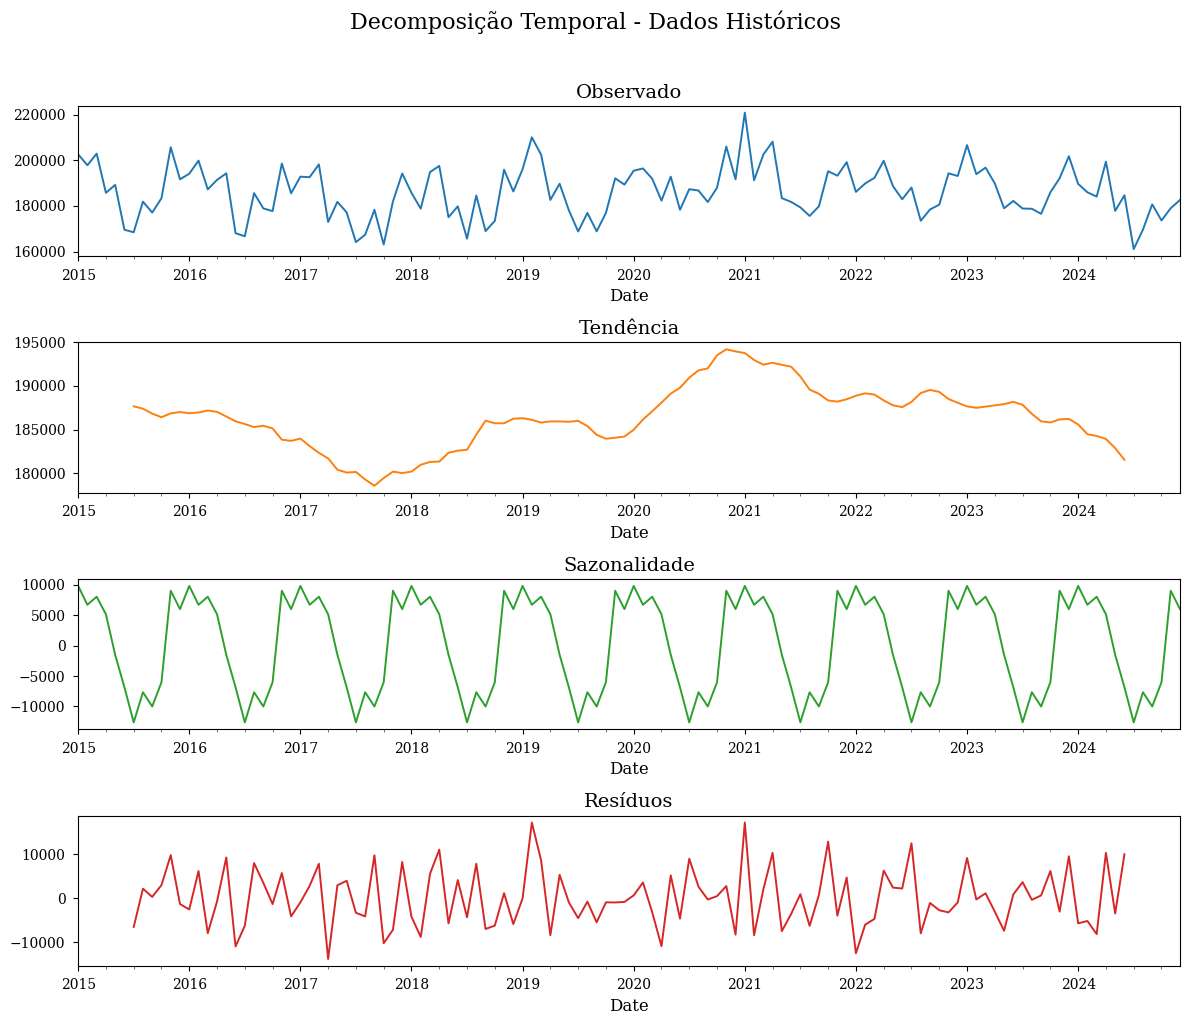

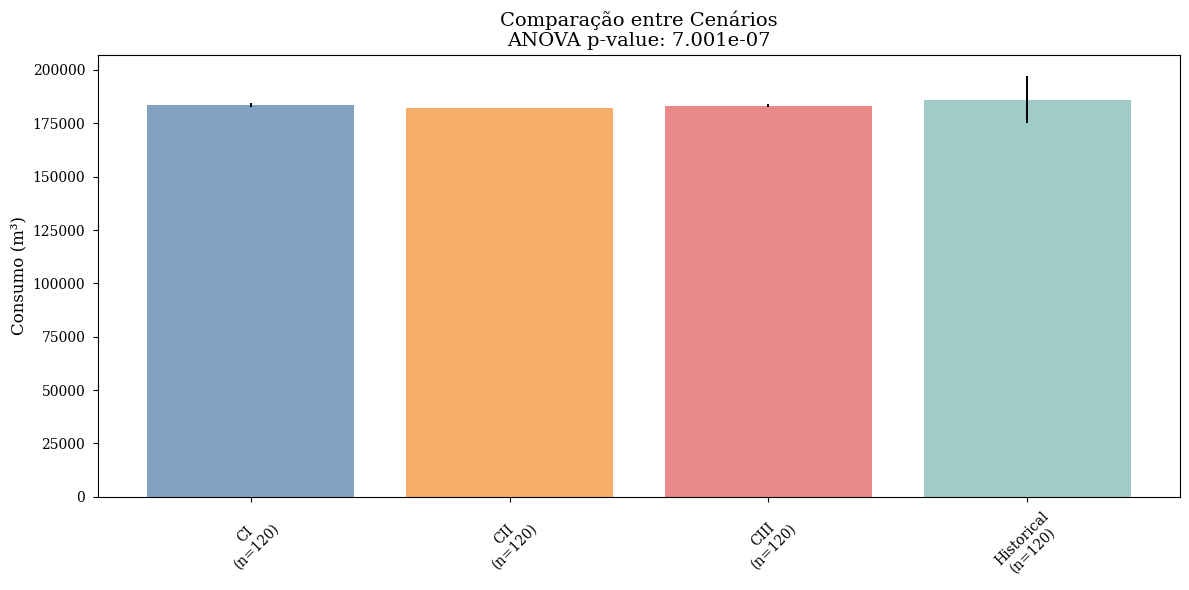

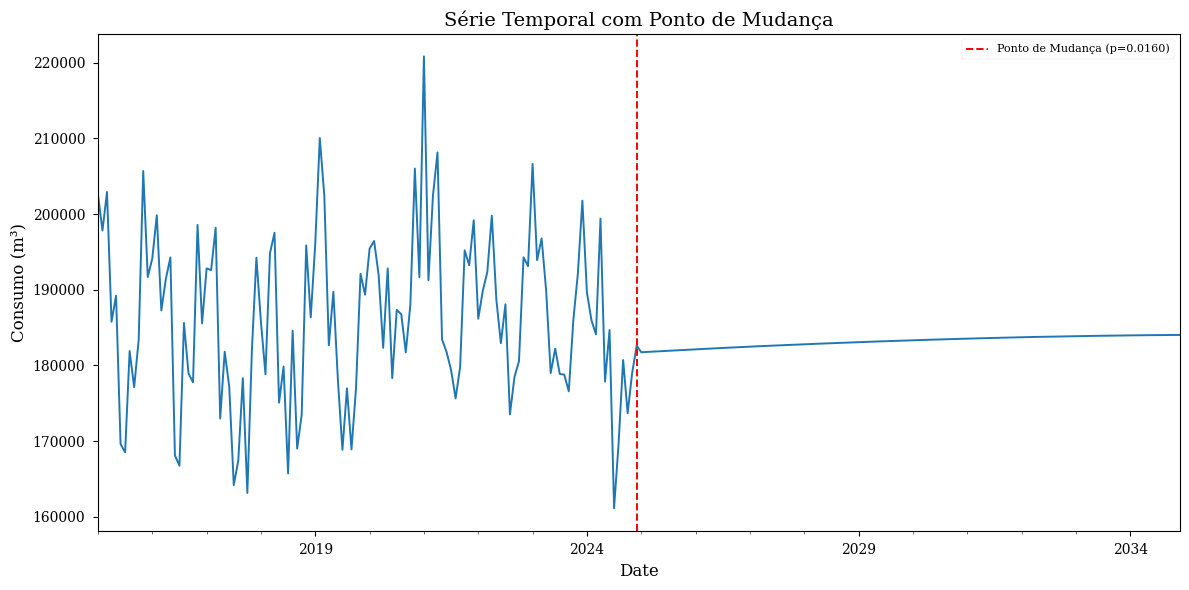

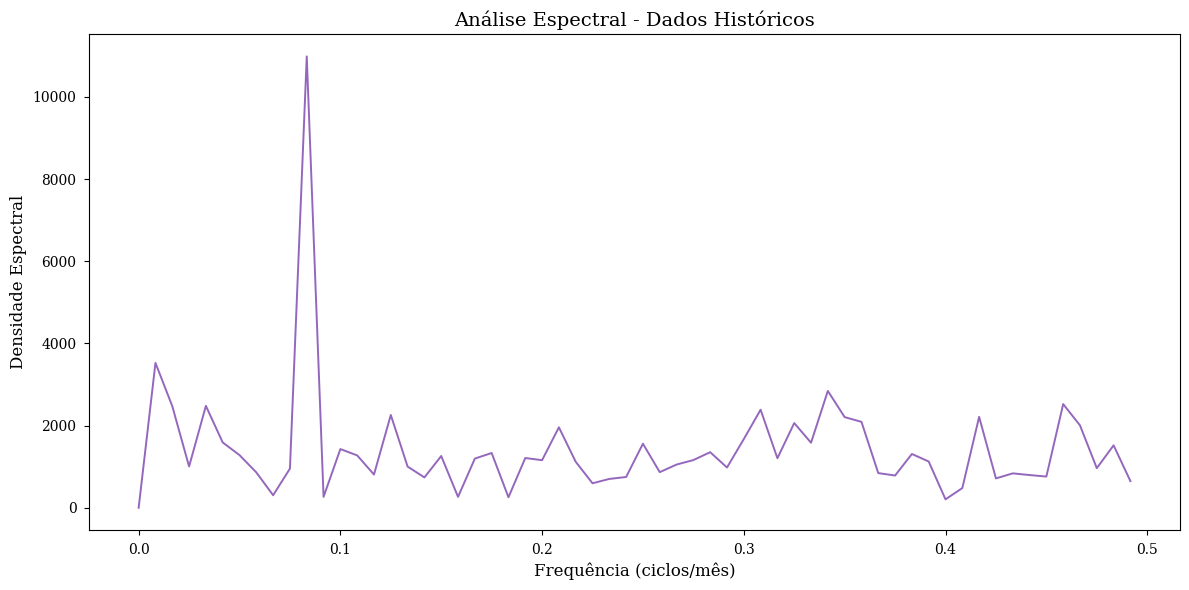

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.fft import fft, fftfreq
import os
from statsmodels.stats.diagnostic import breaks_cusumolsresid  # Alternativa para teste estrutural

# Configuração visual científica
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'figure.titlesize': 16,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.family': 'serif'
})

# 1. Função para carregar dados
def load_data():
    path = 'C:\\Users\\Edmilson\\Gama_Workspace2\\ABMS-WP'
    
    # Cenários
    scenarios = pd.read_csv(os.path.join(path, 'resultados\\dados_simulacao3.csv'))
    scenarios.columns = ['Date', 'CI', 'CII', 'CIII']
    scenarios['Date'] = pd.to_datetime(scenarios['Date'], format='%m/%Y')
    scenarios = scenarios[scenarios['Date'] < pd.to_datetime('2035-01-01')]
    
    # Histórico
    historical = pd.read_csv(os.path.join(path, 'includes\\Tabela_consumo_Itapua_120m_por_mes.csv'), sep=';')
    historical['Date'] = pd.to_datetime(historical['data'])
    historical = historical.rename(columns={'consumo': 'Historical'})[['Date', 'Historical']]
    
    return historical, scenarios

# 2. Análise de Tendência (Decomposição Sazonal)
def trend_analysis(data, title):
    if not hasattr(data.index, 'freq'):
        data = data.asfreq('MS')
    
    try:
        result = seasonal_decompose(data, model='additive', period=12)
        
        fig, axs = plt.subplots(4, 1, figsize=(12, 10))
        result.observed.plot(ax=axs[0], title='Observado', color='#1f77b4')
        result.trend.plot(ax=axs[1], title='Tendência', color='#ff7f0e')
        result.seasonal.plot(ax=axs[2], title='Sazonalidade', color='#2ca02c')
        result.resid.plot(ax=axs[3], title='Resíduos', color='#d62728')
        
        plt.suptitle(f'Decomposição Temporal - {title}', y=1.02)
        plt.tight_layout()
        return result
    except Exception as e:
        print(f"Erro na decomposição: {e}")
        return None

# 3. Teste de Mudança Estrutural Alternativo
def structural_change_test(data, break_point):
    """Implementação alternativa do teste de mudança estrutural"""
    n = len(data)
    if break_point >= n:
        raise ValueError("Ponto de quebra deve ser menor que o tamanho da série")
    
    # Dividir a série em dois períodos
    y1 = data[:break_point]
    y2 = data[break_point:]
    
    # Calcular estatísticas F
    ssr_total = np.sum((data - np.mean(data))**2)
    ssr1 = np.sum((y1 - np.mean(y1))**2)
    ssr2 = np.sum((y2 - np.mean(y2))**2)
    
    f_stat = ((ssr_total - (ssr1 + ssr2))/2)/((ssr1 + ssr2)/(n - 2))
    p_value = 1 - stats.f.cdf(f_stat, 2, n-2)
    
    return f_stat, p_value

# 4. Análise Estatística Completa
def full_statistical_analysis(historical, scenarios):
    # Preparar dados combinados
    dfs = []
    for name, col in [('Historical', 'Historical'), ('CI', 'CI'), 
                     ('CII', 'CII'), ('CIII', 'CIII')]:
        if name == 'Historical':
            temp = historical[['Date', col]].copy()
        else:
            temp = scenarios[['Date', col]].copy()
        temp['Group'] = name
        temp = temp.rename(columns={col: 'Value'})
        dfs.append(temp)
    
    df = pd.concat(dfs).dropna()
    
    # ANOVA
    model = ols('Value ~ Group', data=df).fit()
    anova = anova_lm(model)
    
    # Teste Post-hoc
    tukey = pairwise_tukeyhsd(df['Value'], df['Group'])
    
    # Visualização
    fig, ax = plt.subplots(figsize=(12, 6))
    groups = df.groupby('Group')['Value']
    labels = [f"{name}\n(n={len(group)})" for name, group in groups]
    
    ax.bar(labels, groups.mean(), yerr=groups.std(), 
           color=['#4e79a7', '#f28e2b', '#e15759', '#76b7b2'],
           alpha=0.7, capsize=5)
    
    ax.set_title('Comparação entre Cenários\nANOVA p-value: {:.3e}'.format(anova['PR(>F)'][0]))
    ax.set_ylabel('Consumo (m³)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return {'anova': anova, 'tukey': tukey}

# 5. Análise Espectral Melhorada
def spectral_analysis(data, title):
    n = len(data)
    yf = fft(data.values - np.mean(data.values))
    xf = fftfreq(n, 1)[:n//2]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(xf, 2/n * np.abs(yf[0:n//2]), color='#9467bd')
    ax.set_xlabel('Frequência (ciclos/mês)')
    ax.set_ylabel('Densidade Espectral')
    ax.set_title(f'Análise Espectral - {title}')
    plt.tight_layout()
    
    return xf, yf

# 6. Execução da Análise Completa
def run_full_analysis():
    print("Carregando dados...")
    historical, scenarios = load_data()
    
    print("\n1. Análise de Tendência Temporal...")
    historical_ts = historical.set_index('Date')['Historical']
    trend_analysis(historical_ts, 'Dados Históricos')
    
    print("\n2. Análise Estatística Comparativa...")
    stats_results = full_statistical_analysis(historical, scenarios)
    print("\nResultados ANOVA:")
    print(stats_results['anova'])
    print("\nTeste de Tukey:")
    print(stats_results['tukey'])
    
    print("\n3. Análise de Mudança Estrutural...")
    full_series = pd.concat([historical_ts, scenarios.set_index('Date')['CIII']])
    bp = len(historical_ts)
    f_stat, p_val = structural_change_test(full_series.values, bp)
    print(f"Teste F: {f_stat:.2f}, p-value: {p_val:.4f}")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    full_series.plot(ax=ax, color='#1f77b4')
    ax.axvline(x=historical_ts.index[-1], color='r', linestyle='--',
              label=f'Ponto de Mudança (p={p_val:.4f})')
    ax.set_title('Série Temporal com Ponto de Mudança')
    ax.set_ylabel('Consumo (m³)')
    ax.legend()
    plt.tight_layout()
    
    print("\n4. Análise Espectral...")
    spectral_analysis(historical_ts, 'Dados Históricos')
    
    plt.show()

# Executar análise completa
run_full_analysis()